# Pet Project "Translator"

В этой работе решается задача машинного перевода с помощью encoder-decoder архитектуры, пробуя различные ее реализации

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у нас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы нами будут высококлассно переведены!



*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться...

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Кажется, побуквенное кодирование может помочь! Действительно это так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE - очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма

Мы уверены, что вы научились гуглить и искать полезные материалы в интернете, когда делали домашнее задание по YOLO, поэтому в этот раз просто покажем один из способов, как это можно сделать и затем в своих проектах вы можете брать этот подход и, возможно, как-то улучшать его!

Тем кому очень интересно, как же все работает - заходите в файл vocab.py, очень советуем!

In [ ]:
!wget --no-check-certificate \
    "https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/data.txt" \
    "https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/vocab.py"

--2023-04-24 07:04:18--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905335 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.04s   

2023-04-24 07:04:20 (289 MB/s) - ‘data.txt’ saved [12905335/12905335]

--2023-04-24 07:04:20--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/vocab.py
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 2879 (2.8K) [text/plain]
Saving to: ‘vocab.py’

vocab.py            100%[===================>]   2.81K  --.-KB/s    in 0s      

2023-04-24 07:04:20 (163 MB/s) - ‘vocab.py’ saved [28

In [ ]:
!pip install subword-nmt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:11<00:00, 723.01it/s]


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [ ]:
import numpy as np

In [ ]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [ ]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [ ]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


###  Шаблон простой encoder-decoder модели


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Сначала применим  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и
        логиты для следующих токенов
        """
        prev_gru0_state = prev_state[0]
        output_emb = self.emb_out(prev_tokens)


        new_dec_state = self.dec0(output_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state

        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):

            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:

# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))
assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
kitchens roof@@ rijeka satellite sena mallorca furnishings josé lin@@ vallarta ik 60 trains mosel@@ starting americas ego old ź nang reme iz@@ cos@@ limassol bathrobe
kitchens roof@@ rijeka satellite sena mallorca furnishings josé sto albergo vod@@ timber san movie rist@@ we sibir@@ tionally outskirts block line state using need ama
kitchens ital apart + coo@@ adri@@ sicil@@ bathtub sett@@ iz@@ extras color@@ check biarritz timber sagr@@ giardini necess@@ james wal@@ wal@@ asts pizz@@ port@@ katerin@@


### Loss

Тут нечего объяснять, напишем лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг

In [ ]:
def loss_function(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]


    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities всех токеноы на всех шагах
    softmax = nn.Softmax(-1)
    logprobs_seq = (-torch.log(softmax(logits_seq))).to(device) # [batch_size, out_len, num_tokens]

    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1).to(device) # [batch_size, out_len]


    # cross-entropy по всем токенам где mask == True
    return  (torch.sum(logp_out * mask) / torch.sum(model.inp_voc.compute_mask(inp)).to(torch.float32)).to(device) # тут должен получиться скаляр!

In [ ]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5356, device='cuda:0', grad_fn=<DivBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU.
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0019756304728269156

### Training loop

Напишем цикл обучения и подсчитаем метрики! И пройдем assert по качеству

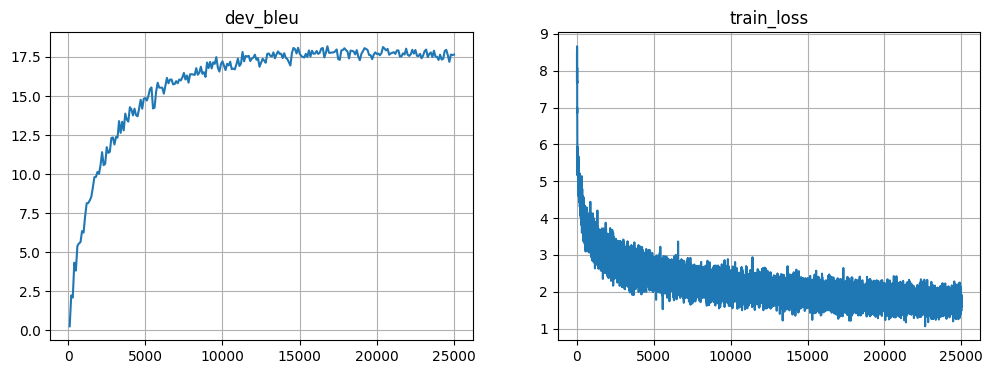

Mean loss=1.705


Total: 100%|██████████████████████████████| 25000/25000 [18:58<00:00, 21.96it/s]


In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

num_iter = 25000

for i in trange(num_iter, ncols=80, desc='Total'):
  step = len(metrics['train_loss']) + 1

  batch_ix = np.random.randint(len(train_inp), size=batch_size)
  batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
  batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

  loss = loss_function(model, batch_inp, batch_out)


  loss.backward()
  opt.step()
  opt.zero_grad()

  metrics['train_loss'].append((step, loss.cpu().detach().numpy()))

  if step % 100 == 0:
      metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

      clear_output(True)
      plt.figure(figsize=(12,4))
      for i, (name, history) in enumerate(sorted(metrics.items())):
          plt.subplot(1, len(metrics), i + 1)
          plt.title(name)
          plt.plot(*zip(*history))
          plt.grid()
      plt.show()
      print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)



In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "Мы можем лучше! попробуем еще раз)"

In [ ]:
 np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

17.591169865604588

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
a free shuttle service and free parking are available on site .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
r@@ aven@@ is is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
featuring a private beach area , apartments a private beach area is a 5 - minute walk from the beach and 2 . 5 km from the beach .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
apartment saint mark metres from hagia sophia cathedral is 500 metres from the city .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private bathrooms also come with towels .



## Attention is all you need

### Attention слой
Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов:
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ = torch.tanh):
        super().__init__()
        self.name = name
        self.enc_size = enc_size
        self.dec_size = dec_size
        self.hid_size = hid_size

        # опишем все слои, которые нужны Attention
        self.activ = activ
        self.e_w = nn.Linear(self.hid_size, self.hid_size).weight.to(device)
        self.d_w = nn.Linear(self.hid_size, self.hid_size).weight.to(device)
        self.o_w = nn.Linear(self.hid_size, 1).weight.to(device)


    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """
        # считаем логиты

        logits = torch.matmul(self.activ(torch.matmul(enc, self.e_w) + torch.matmul(dec.unsqueeze(1), self.d_w)), torch.transpose(self.o_w, 0, 1))
        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        lower_cap = -1e9 * torch.ones_like(logits)

        logits = torch.where(inp_mask.unsqueeze(-1), logits, lower_cap )

        # Применим softmax
        softmax = nn.Softmax(dim=1)
        probs = softmax(logits)

        # Подсчитаем выход attention используя enc состояния и вероятностями
        attn = torch.sum(probs * enc, axis = 1)

        probs = torch.reshape(probs, [inp_mask.shape[0],-1])

        return attn, probs

### Seq2seq model with attention (2 points)

Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используем предыдущее состояние декодера, и написанный слой Attention




In [ ]:
class AttentiveModel(BaseModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """Переводчик с Attention"""
        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        # initialize layers
        self._name = name
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attn = AttentionLayer("attnLayer", len(inp_voc), len(out_voc), attn_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """

        # делаем encode
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        outputs = np.stack(enc_seq.cpu().detach().numpy(), axis = 0)
        outputs = torch.from_numpy(outputs).to(device)

        mask = model.inp_voc.compute_mask(inp)
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        # применяем attention слой для скрытых состояний
        attn_val, first_attn_probas = self.attn(enc_seq, dec_start, mask)

        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention

        first_state = [dec_start, outputs, mask, attn_val, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """

        out_emb = self.emb_out(prev_tokens)
        attn_val = prev_state[3]
        # Concat embedding with attention context

        out_emb = torch.concat([out_emb, attn_val], dim=-1)
        # Apply decoding cell to attention concatenated embedding and previous state to get output_decoding and new state

        # new_dec_state = self.dec0(output_emb, prev_gru0_state)
        # output_logits = self.logits(new_dec_state)

        # return [new_dec_state], output_logits

        dec_state = self.dec0(out_emb, prev_state[0])
        # Apply the fully connected layer to get the logits
        output_logits = self.logits(dec_state)
        # Apply the attention layer to the new output from decoding cell (output_dec)
        # We use prev_state[1] (encoder output) and prev_state[2] (mask)

        attn_val, attn_prob = self.attn(prev_state[1], dec_state, prev_state[2])
        # we store the attn_val and attn_prob in the new_dec_state

        new_dec_state = [dec_state, prev_state[1], prev_state[2],  attn_val, attn_prob]
        return new_dec_state, output_logits


### Обучение модели

Обучим AttentiveModel и пройдем assert по качеству

In [ ]:
model = AttentiveModel("AttentionModel", inp_voc, out_voc).to(device)

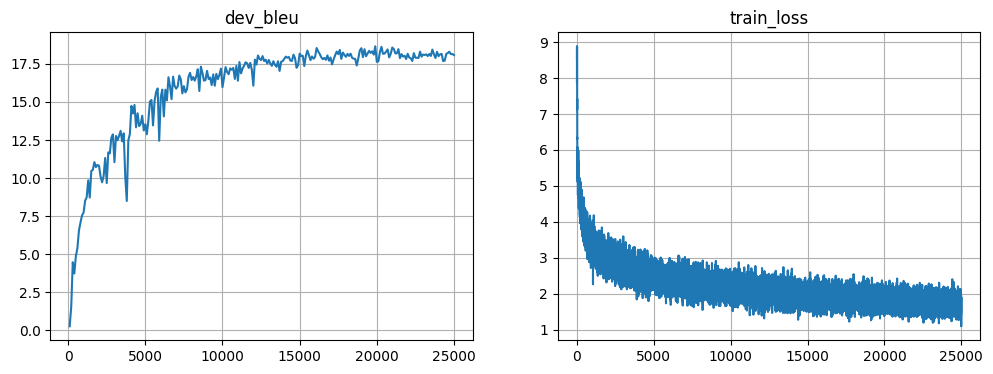

Mean loss=1.580


Total: 100%|██████████████████████████████| 25000/25000 [41:48<00:00,  9.97it/s]


In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
metrics = {'train_loss': [], 'dev_bleu': [] }

opt = torch.optim.AdamW(model.parameters())
batch_size = 32

num_iter = 25000

for i in trange(num_iter, ncols=80, desc='Total'):
  step = len(metrics['train_loss']) + 1
  batch_ix = np.random.randint(len(train_inp), size=batch_size)
  batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
  batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

  loss = loss_function(model, batch_inp, batch_out)


  loss.backward()
  opt.step()
  opt.zero_grad()

  metrics['train_loss'].append((step, loss.cpu().detach().numpy()))

  if step % 100 == 0:
      metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

      clear_output(True)
      plt.figure(figsize=(12,4))
      for i, (name, history) in enumerate(sorted(metrics.items())):
          plt.subplot(1, len(metrics), i + 1)
          plt.title(name)
          plt.plot(*zip(*history))
          plt.grid()
      plt.show()
      print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)



In [ ]:
final_BLEU = print("Final BLEU", metrics['dev_bleu'][-1])

assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 23, "Ты можешь больше! попробуй еще раз)"

In [ ]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

17.00325046729555

## Как решать NLP задачу? Дообучить модель из huggingface

Можно получить отлично качество генерации текста, написав при этом не очень много строк кода.
Это отличная идея!

### Huggingface модель

Возьмем модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучим на наших данных и посмотрим, какое качество

In [ ]:
!pip install transformers
!pip install transformers[sentencepiece]
!pip install pip install sacremoses
!pip install datasets
!pip install sacrebleu
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.9 MB/s eta 0:00:00


In [ ]:
# Создание датасета
from datasets import Dataset
from datasets.dataset_dict import DatasetDict
x_train, y_train = [], []
for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        x_train.append(src_line)
        y_train.append(dst_line)

d = {'train':Dataset.from_dict({'ru':y_train,'en':x_train})}
raw_dataset = DatasetDict(d)
split_dataset = raw_dataset["train"].train_test_split(test_size=3000, seed=42)

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-ru-en"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

In [ ]:
# tokenized dataset
max_length = 256
def preprocess_function(examples):
    inputs = [ex for ex in examples["ru"]]
    targets = [ex for ex in examples["en"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs
tokenized_dataset = split_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=split_dataset["train"].column_names,
)
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)



Map:   0%|          | 0/47000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
# Метрика  BLEU
import evaluate
metric = evaluate.load("sacrebleu")
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 15.2 MB/s eta 0:00:00


In [ ]:
# dataloader and accelerator
from torch.utils.data import DataLoader

tokenized_dataset.set_format("torch")
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=32,
)
eval_dataloader = DataLoader(
    tokenized_dataset["test"], collate_fn=data_collator, batch_size=32
)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)
from transformers import get_scheduler

num_train_epochs = 1
num_update_steps_per_epoch = 2000
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import Repository, get_full_repo_name
from huggingface_hub import create_repo
model_name = "marian-finetuned-hotels-ru-to-en-accelerate"
repo_name = get_full_repo_name(model_name)


In [ ]:
output_dir = "marian-finetuned-hotels-ru-to-en-accelerate"
repo = Repository(output_dir, clone_from=repo_name)


/content/marian-finetuned-hotels-ru-to-en-accelerate is already a clone of https://huggingface.co/KarenYer/marian-finetuned-hotels-ru-to-en-accelerate. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
# Training loop
def postprocess(predictions, labels):
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    return decoded_preds, decoded_labels
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    # Evaluation
    model.eval()
    results = []
    for batch in tqdm(eval_dataloader):
        step = len(results) + 1
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=128,
            )
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        generated_tokens = accelerator.pad_across_processes(
            generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
        )
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(generated_tokens)
        labels_gathered = accelerator.gather(labels)

        decoded_preds, decoded_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=decoded_preds, references=decoded_labels)
        results.append(metric.compute()['score'])
        if step % 10 == 0:
          print(f"step {step}, BLEU score: {results[-1]:.2f}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

 15%|█▍        | 1469/10000 [19:37<1:53:59,  1.25it/s]

 11%|█         | 10/94 [00:16<02:10,  1.55s/it]

step 10, BLEU score: 30.79



 21%|██▏       | 20/94 [00:33<02:00,  1.63s/it]

step 20, BLEU score: 28.69



 32%|███▏      | 30/94 [00:52<01:49,  1.71s/it]

step 30, BLEU score: 31.44



 43%|████▎     | 40/94 [01:07<01:19,  1.47s/it]

step 40, BLEU score: 34.61



 53%|█████▎    | 50/94 [01:24<01:10,  1.59s/it]

step 50, BLEU score: 34.23



 64%|██████▍   | 60/94 [01:40<00:54,  1.61s/it]

step 60, BLEU score: 30.92



 74%|███████▍  | 70/94 [01:57<00:40,  1.68s/it]

step 70, BLEU score: 33.71



 85%|████████▌ | 80/94 [02:13<00:25,  1.81s/it]

step 80, BLEU score: 31.71



 96%|█████████▌| 90/94 [02:29<00:06,  1.67s/it]

step 90, BLEU score: 28.43



100%|██████████| 94/94 [02:34<00:00,  1.64s/it]


In [ ]:
final_BLEU = print("Final BLEU", np.mean(np.array(results)[-10:], axis=0))
# аналогично прошлым пунктам

assert np.mean(np.array(results)[-10:], axis=0) > 27, "Мы можем больше! попробуем еще раз)"

Final BLEU 29.788663916086215


In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "marian-finetuned-hotels-ru-to-en-accelerate"
translator = pipeline("translation", model=model_checkpoint)
for inp_line, trans_line in zip(dev_inp[::500], dev_inp[::500]):
    print(inp_line)
    print(translator(trans_line))
    print()

в распоряжении гостей общая кухня и общая гостиная .
[{'translation_text': 'There is a shared kitchen and a shared living room at the property.'}]

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
[{'translation_text': 'The property also offers bike hire, shuttle service and free parking.'}]

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
[{'translation_text': 'Ki (3 km) is 26 km away.'}]

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
[{'translation_text': 'Located a 5-minute walk from the beach on the beach, this air-conditioned apartment features a shared pool, garden, air conditioning and a sun terrace.'}]

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
[{'translation_text': 'Located in Moscow, 200 metres from Big Theatre, Apartamento(S2@O2 2) is a self